In [ ]:
%pip install scikit-lego

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.9/188.9 kB 12.3 MB/s eta 0:00:00


In [ ]:
!pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklego.linear_model import LADRegression

pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 500
pd.options.display.max_rows = 100

In [ ]:
# this cell may take up to 30 seconds to run to convert the Hugginface Dataset class to Pandas DataFrame for better EDA

from datasets import load_dataset
import pandas as pd

HF_SPOTIFY_DATASET_PATH = "maharshipandya/spotify-tracks-dataset"
# https://huggingface.co/datasets/maharshipandya/spotify-tracks-dataset

ds = load_dataset(HF_SPOTIFY_DATASET_PATH) #only has 'train' split as key
df = pd.DataFrame(ds["train"])
df.head()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.68k [00:00<?, ?B/s]

dataset.csv:   0%|          | 0.00/20.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/114000 [00:00<?, ? examples/s]

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Soundtrack),Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


##EDA

Text(0, 0.5, 'Variables')

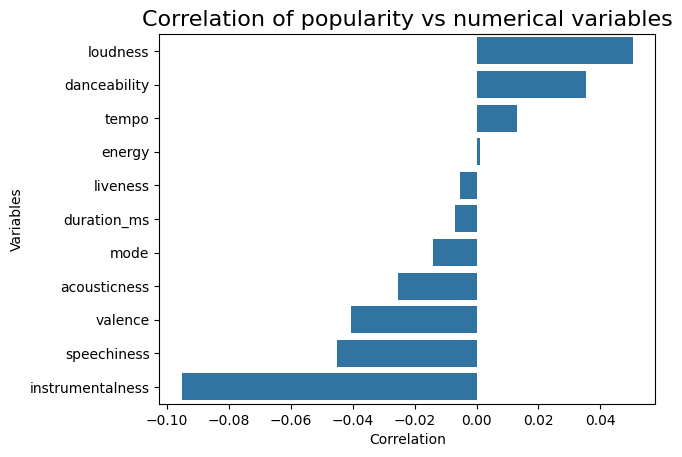

In [ ]:
data_numbers = df.select_dtypes(include=['int64', 'float64'])
sorted_corr = data_numbers.corr()["popularity"].drop(["popularity","key","time_signature","Unnamed: 0"]).sort_values(ascending=False)
sns.barplot(x=sorted_corr.values,y=sorted_corr.index)
plt.title("Correlation of popularity vs numerical variables", fontsize=16)
plt.xlabel("Correlation")
plt.ylabel("Variables")

Instrumentalness has the strongest negative correlation (albeit not very strong).  Let's analyze the relationship between instrumentalness and popularity.  

##Partitioning Data
First, we will partition the data into training, validation, and testing into a 60/20/20 split.  Simple random sampling should be sufficient here.  Another possibility is stratified sampling, but possible strata such as genre are equally represented across the data

In [ ]:
df["track_genre"].value_counts()

,count
track_genre,
acoustic,1000
punk-rock,1000
progressive-house,1000
power-pop,1000
pop,1000
...,...
folk,1000
emo,1000
electronic,1000


In [ ]:
cols_to_keep = ["instrumentalness"]

X = df[cols_to_keep]
y = df["popularity"]

#X_train will have 60% of the data, X_test_val will have 40%
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.4, random_state=42)

#X_val and X_test will have 50% of X_test_val
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)

#Verify that we have a 60/20/20 split
total_samples = len(X)
train_samples = len(X_train)
val_samples = len(X_val)
test_samples = len(X_test)

print(f"Total samples: {total_samples}")
print(f"Training samples: {train_samples}")
print(f"Validation samples: {val_samples}")
print(f"Test samples: {test_samples}")

Total samples: 114000
Training samples: 68400
Validation samples: 22800
Test samples: 22800


We have 60% training, 20% validation, 20% test.

#Steps 1 and 2
Feature selected is instrumentalness.

In [ ]:
unnamed = [10,50,24,815,920,487,124,425]
sample_ames_clean = df.loc[unnamed]
sample_ames_clean

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
10,10,4mzP5mHkRvGxdhdGdAH7EJ,Zack Tabudlo,Episode,Give Me Your Forever,74,244800,False,0.627,0.363,8,-8.127,1,0.0291,0.279,0.000000,0.0928,0.301,99.905,4,acoustic
50,50,72xTsTouZ5nBmASX8k1XCW,Highland Peak,Trampoline (Acoustic),Trampoline - Acoustic,46,213098,False,0.596,0.200,0,-10.424,0,0.0305,0.910,0.000183,0.0884,0.308,107.893,4,acoustic
24,24,3Hn3LfhrQOaKihdCibJsTs,Jason Mraz,Human - Best Adult Pop Tunes,Unlonely,0,231266,False,0.796,0.667,5,-4.831,0,0.0392,0.381,0.000000,0.2210,0.754,97.988,4,acoustic
815,815,10a6GUpyRLdfadUPRL5wBg,Postcards & Polaroids;Sad Boy,Covers EP,Supermarket Flowers,45,145753,False,0.463,0.156,6,-13.416,1,0.1890,0.890,0.000000,0.1150,0.478,180.191,4,acoustic
920,920,6apacvSkVWWtCxc68FBsZV,Carly Lyman;Jason Lux,(I Just) Died In Your Arms [Acoustic],(I Just) Died In Your Arms - Acoustic,47,211364,False,0.747,0.221,0,-10.528,0,0.0358,0.930,0.000000,0.1160,0.369,118.029,4,acoustic
487,487,2AN3wNGUW0IgzfuurtVEDS,Mance Lipscomb,The Best of Mance Lipscomb,Sugar Babe,31,124400,False,0.554,0.400,3,-11.806,1,0.0699,0.979,0.348000,0.1020,0.547,101.191,4,acoustic
124,124,4zcMBfbQZvBSHQBGDd6gsN,JJ Heller,You Already Know,You Already Know,57,214360,False,0.496,0.117,0,-12.884,1,0.0301,0.933,0.000000,0.1260,0.318,78.068,4,acoustic
425,425,0voYwjeuMfvXlF76oesZKu,Joshua Radin,"Here, Right Now","Here, Right Now",56,183213,False,0.496,0.391,10,-9.844,1,0.0311,0.826,0.012600,0.1080,0.492,108.868,4,acoustic


In [ ]:
# create a clean version of the preview dataset and select only the saleprice and gr_live_area columns
sample_ames_clean = sample_ames_clean[['instrumentalness', 'popularity']]
sample_ames_clean

,instrumentalness,popularity
10,0.000000,74
50,0.000183,46
24,0.000000,0
815,0.000000,45
920,0.000000,47
487,0.348000,31
124,0.000000,57
425,0.012600,56


In [ ]:
px.scatter(sample_ames_clean, x='instrumentalness', y='popularity')

##Generating Fits


### LAD fit

In [ ]:
lad_fit = LADRegression()
lad_fit.fit(X=np.array(sample_ames_clean['instrumentalness']).reshape(-1, 1),
            y=sample_ames_clean['popularity'])
lad_fit.intercept_, lad_fit.coef_[0]

(46.99999999999999, -45.977011494252864)

In [ ]:
# plot the LAD fitted line on top of the scatterplot
fig = px.scatter(sample_ames_clean, x='instrumentalness', y='popularity')
fig.add_trace(
    go.Scatter(x=sample_ames_clean['instrumentalness'],
               y=lad_fit.intercept_ + sample_ames_clean['instrumentalness'] * lad_fit.coef_[0],
               mode='lines')
)

In [ ]:
# predict the sale price of a house with 1,000 square feet of living area using the LAD model
lad_fit.predict(np.array(2000).reshape(-1, 1))

array([-91907.02298851])

###LS fit

In [ ]:
ls_fit = LinearRegression()
ls_fit.fit(X=np.array(sample_ames_clean['instrumentalness']).reshape(-1, 1),
                y=sample_ames_clean['popularity'])
ls_fit.intercept_, ls_fit.coef_[0]

(46.45559921280216, -43.36344479206971)

In [ ]:
# plot the LAD and LS fitted line on top of the scatterplot
fig = px.scatter(sample_ames_clean, x='instrumentalness', y='popularity')
fig.add_trace(
    go.Scatter(x=sample_ames_clean['instrumentalness'],
               y=lad_fit.intercept_ + sample_ames_clean['instrumentalness'] * lad_fit.coef_[0],
               mode='lines',
               name='LAD',
               line={'dash': 'dash',
                     'color': 'black'})
)
fig.add_trace(
    go.Scatter(x=sample_ames_clean['instrumentalness'],
               y=ls_fit.intercept_ + sample_ames_clean['instrumentalness'] * ls_fit.coef_[0],
               mode='lines',
               name='LS',
               line={'dash': 'solid',
                     'color': 'black'})
)

In [ ]:
ls_fit.predict(np.array(2000).reshape(-1, 1))

array([-86680.43398493])

### Plot LS and LAD to Training Set

In [ ]:
lad_area_fit = LADRegression()
lad_area_fit.fit(X=X_train, y= y_train)

LADRegression()

In [ ]:
ls_area_fit = LinearRegression()
ls_area_fit.fit(X=X_train, y= y_train)

LinearRegression()

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression, QuantileRegressor



# Convert X_train to a 1D array for plotting
X_train_flat = X_train.values.ravel()

# Create the scatter plot of gr_liv_area against sale_price
fig = go.Figure()

# Add the scatter plot first
fig.add_trace(
    go.Scatter(
        x=X_train_flat,
        y=y_train,
        mode='markers',
        name='Training Data',
        marker=dict(color='blue', opacity=0.5)
    )
)

# Add the LAD regression line on top
fig.add_trace(
    go.Scatter(
        x=X_train_flat,
        y=lad_area_fit.intercept_ + X_train_flat * lad_area_fit.coef_[0],
        mode='lines',
        name='LAD',
        line={'dash': 'dash', 'color': 'black'}
    )
)

# Add the LS regression line on top
fig.add_trace(
    go.Scatter(
        x=X_train_flat,
        y=ls_area_fit.intercept_ + X_train_flat * ls_area_fit.coef_[0],
        mode='lines',
        name='LS',
        line={'dash': 'solid', 'color': 'black'}
    )
)

# Set titles and labels
fig.update_layout(
    title='Intrumental vs. Popularity',
    xaxis_title='Instrumental',
    yaxis_title='Popularity'
)

# Display the figure
fig.show()


Output hidden; open in https://colab.research.google.com to view.

### Performance


In [ ]:
pred_train_df = pd.DataFrame(
    {"actual": y_train,
     "ls_pred": ls_fit.predict(X_train),
     "lad_pred": lad_fit.predict(X_train)}
)
pred_train_df

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning:

X has feature names, but LinearRegression was fitted without feature names



,actual,ls_pred,lad_pred
103465,62,46.449919,46.993977
93967,0,46.455599,47.000000
72677,26,45.579658,46.071264
63669,55,45.627357,46.121839
92494,27,46.453869,46.998166
...,...,...,...
76820,49,46.413537,46.955402
110268,30,6.821411,4.977011
103694,0,46.455599,47.000000
860,44,46.455599,47.000000


In [ ]:
# calculate the rMSE, MAE, MAD, correlation, and R2 of the true price with the LS and LAD predictions
print('LS rMSE:', np.sqrt(mean_squared_error(pred_train_df['actual'], pred_train_df['ls_pred'])))
print('LS MAE:', mean_absolute_error(pred_train_df['actual'], pred_train_df['ls_pred']))
print('LS MAD:', np.median(np.abs(pred_train_df['actual'] - pred_train_df['ls_pred'])))
print('LS correlation:', np.corrcoef(pred_train_df['actual'], pred_train_df['ls_pred'])[0, 1])
print('LS R2:', r2_score(pred_train_df['actual'], pred_train_df['ls_pred']))
print()
print('LAD rMSE:', np.sqrt(mean_squared_error(pred_train_df['actual'], pred_train_df['lad_pred'])))
print('LAD MAE:', mean_absolute_error(pred_train_df['actual'], pred_train_df['lad_pred']))
print('LAD MAD:', np.median(np.abs(pred_train_df['actual'] - pred_train_df['lad_pred'])))
print('LAD correlation:', np.corrcoef(pred_train_df['actual'], pred_train_df['lad_pred'])[0, 1])
print('LAD R2:', r2_score(pred_train_df['actual'], pred_train_df['lad_pred']))

LS rMSE: 25.743319712449924
LS MAE: 20.738647006185452
LS MAD: 17.544400787197837
LS correlation: 0.09664267153037186
LS R2: -0.3305786084395481

LAD rMSE: 26.143775727936724
LAD MAE: 21.05688895750487
LAD MAD: 17.999999999999993
LAD correlation: 0.09664267153037177
LAD R2: -0.3722968138831475


#Step 3
Across all metrics, the LAD fit has a higher score.

#step 4
Both LS and LAD have low R² Values -0.33 and LAD R². This shows that the model is not able to capture a relationship between the predictor and the target and that it performs worse than average.

In addition, a correlation coefficient of 0.0966 for both models suggests a very weak linear relationship between the two.

Finally, both RMSE and MAE are high, showing high deviation from the prediction to the real values. All of these point to underfitting.

## Step 5


In [ ]:
X_std = (X_train - X_train.mean()) / X_train.std()
y = y_train

In [ ]:
from sklearn.linear_model import  Ridge, Lasso
from sklearn.model_selection import cross_val_score, cross_validate
# use 10-fold cross-validation to select the best lambda (alpha) value for the lasso regression model

# define the alpha values to test
# note that the start/stop values in the first two arguments are the exponents
alphas = np.logspace(-2, 1, 100)

# create an empty list to store the cross-validation scores
lasso_cv_scores = []

# create a for loop to compute the cross-validation score for each alpha value
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso_cv = cross_validate(estimator=lasso,
                              X=X_std,
                              y=y,
                              cv=5)
    lasso_cv_scores.append({'alpha': alpha,
                            'log_alpha': np.log(alpha),
                            'test_mse': -np.mean(lasso_cv['test_score'])})

# convert the cross-validation scores into a data frame
lasso_cv_scores_df = pd.DataFrame(lasso_cv_scores)

# plot the cross-validation scores as a function of alpha
px.line(lasso_cv_scores_df,
        x='log_alpha',
        y='test_mse',
        title='Lasso')

In [ ]:
# identify the value of alpha that minimizes the cross-validation score for lasso
lasso_alpha_min = lasso_cv_scores_df.sort_values(by='test_mse').head(1).alpha.values[0]
# compute the min MSE and the SE of the MSE
mse_se_lasso = lasso_cv_scores_df['test_mse'].std() / np.sqrt(10)
mse_min_lasso = lasso_cv_scores_df['test_mse'].min()

# identify the value of alpha that minimizes the cross-validation score for lasso within 1SE
lasso_alpha_1se = lasso_cv_scores_df[(lasso_cv_scores_df['test_mse'] <= mse_min_lasso + mse_se_lasso) &
                                     (lasso_cv_scores_df['test_mse'] >= mse_min_lasso - mse_se_lasso)].sort_values(by='alpha', ascending=False).head(1).alpha.values[0]


In [ ]:
print('Lasso (min): ', lasso_alpha_min)
print('Lasso (1SE): ', lasso_alpha_1se)

Lasso (min):  0.1
Lasso (1SE):  0.29836472402833397


In [ ]:
# use lasso_alpha_min to fit the lasso regression model
lasso_min_fit = Lasso(alpha=lasso_alpha_min).fit(X=X_std, y=y)
lasso_1se_fit = Lasso(alpha=lasso_alpha_1se).fit(X=X_std, y=y)

Lasso(alpha=0.1)

In [ ]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# lasso_reg = Lasso()
# #Fitting the Training data to the Lasso regressor
# lasso_reg.fit(X_train,y_train)
# #Predicting for X_test
# print("nnLasso SCORE : ", score())

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
lasso_min_pred = lasso_min_fit.predict(X_test)
lasso_1se_pred = lasso_1se_fit.predict(X_test)

print("nnLasso (min) SCORE : ", r2_score(lasso_min_pred, y_test))
print("nnLasso (1se) SCORE : ", r2_score(lasso_1se_pred, y_test))


nnLasso (min) SCORE :  -1205.6652156082282
nnLasso (1se) SCORE :  -1477.5062846781627


### Our regularization does not appear to be performing very well based on the data